In [1]:
## For debbugging
%load_ext autoreload

In [2]:
# import os
import sys
from pathlib import Path
module_path = Path('.').resolve().parents[1]
if module_path not in sys.path:
    sys.path.append(str(module_path))


In [3]:
## for debugging:
# %aimport mlp.keyword
# %aimport mlp.tools
%aimport mlp.kex
%aimport app.test_app
%aimport mlp.tree
%aimport mlp.plot
%autoreload 1
from mlp.kex import *
from mlp.tree import node_adj_mat, tag_network, tag_df_network
from mlp.plot import hv_net
from bokeh.palettes import Viridis10, Category10_6
import networkx as nx


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tqdm
%matplotlib inline

In [5]:
%gui qt
import PyQt5.QtWidgets as qw
from app.test_app import MyWindow
from PyQt5 import QtCore



In [6]:
import dask.dataframe as dd
import dask
import string
from fuzzywuzzy import process as zz


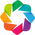

In [7]:
import holoviews as hv
hv.extension('bokeh')

%opts Graph [width=600 height=400]

In [18]:
data_dir = module_path/'data'/'mine_data'

df = dd.read_csv(data_dir/'mine_data.csv')


nlp_select = NLPSelect(columns = ['OriginalShorttext'])

raw_text = nlp_select.transform(df)

  BscStartDate Asset        OriginalShorttext PMType     Cost
0   2004-07-01     A        BUCKET WON'T OPEN   PM01   183.05
1   2005-03-20     A  L/H BUCKET CYL LEAKING.   PM01   407.40
2   2006-05-05     A              SWAP BUCKET   PM01     0.00
3   2006-07-11     A         FIT BUCKET TOOTH   PM01     0.00
4   2006-11-10     A       REFIT BUCKET TOOTH   PM01  1157.27
0          BUCKET WON'T OPEN
1    L/H BUCKET CYL LEAKING.
2                SWAP BUCKET
3           FIT BUCKET TOOTH
4         REFIT BUCKET TOOTH
dtype: object


### Build Vocab

In [9]:
tex = TokenExtractor()
toks = tex.fit_transform(raw_text)
print(tex.vocab_)

['replace' 'bucket' 'repair' ... '1fitter' '36' 'exd']


In [78]:
vocab_fname = data_dir/'mel_vocab.csv'
# vocab_fname = data_dir/'mine_vocab_app.csv'

vocab = tex.annotation_assistant(init=vocab_fname)

intialized successfully!


In [16]:
if __name__ == '__main__':

    app = QtCore.QCoreApplication.instance()
    if app is None:
        app = app = qw.QApplication(sys.argv)

    window = MyWindow(vocab_filename=vocab_fname)
    window.show()

    app.exec_()

In [11]:
vocab = tex.annotation_assistant(filename=vocab_fname)

file already exists, importing...


### Extract Keywords

In [79]:
tag_df = tags_to_df(tag_extractor(tex, raw_text, toks, vocab))

HBox(children=(IntProgress(value=0, description='Category Loop', max=4), HTML(value='')))

HBox(children=(IntProgress(value=0, description='I token loop', max=187), HTML(value='')))

HBox(children=(IntProgress(value=0, description='NA token loop', max=1256), HTML(value='')))

HBox(children=(IntProgress(value=0, description='P token loop', max=33), HTML(value='')))

HBox(children=(IntProgress(value=0, description='S token loop', max=24), HTML(value='')))

HBox(children=(IntProgress(value=0, description='U token loop', max=112), HTML(value='')))

In [80]:
# how many instances of each keyword class are there?
print('named entities: ')
print('I\tItem\nP\tProblem\nS\tSolution\nR\tRedundant')
print('U\tUnknown\nX\tStop Word')
print('total tokens: ', vocab.NE.notna().sum())
print('total tags: ', vocab.groupby("NE").nunique().alias.sum())
vocab.groupby("NE").nunique()

named entities: 
I	Item
P	Problem
S	Solution
R	Redundant
U	Unknown
X	Stop Word
total tokens:  509
total tags:  355


,NE,alias,notes,score
NE,,,,
I,1,187,27,278
P,1,33,11,48
S,1,24,13,57
U,1,111,47,126


Tag completeness: 0.85 +/- 0.19
Tag empty: 177, or 3.23%


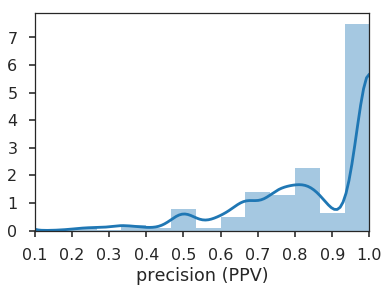

In [81]:
# tag-completeness of work-orders?
wo_tot = len(df)
tag_comp = 1-(tag_df['NA'].sum(axis=1)/tag_df.sum(axis=1))
              
print(f'Tag completeness: {tag_comp.mean():.2f} +/- {tag_comp.std():.2f}')
with sns.axes_style('ticks') as style,\
sns.plotting_context('poster') as context:
    sns.distplot(tag_comp.dropna(), bins=15, kde_kws={'cut':0})
    plt.xlim(0.1, 1.0)
    plt.xlabel('precision (PPV)')
    # sns.kdeplot()

# tag-empty? 
tag_empt = ((tag_df['I'].sum(axis=1)==0)&(tag_df['P'].sum(axis=1)==0)&(tag_df['S'].sum(axis=1)==0)).sum()
print(f'Tag empty: {tag_empt}, or {tag_empt/wo_tot:.2%}')

## WORK BELOW HERE

In [82]:
colors = {
            'P':'#C0504D',
            'S':'#7ABC32',
            'I':'#4F81BD',
            'U':'#ffc000',
            'NA':'gray',
            'X':'black'
        }

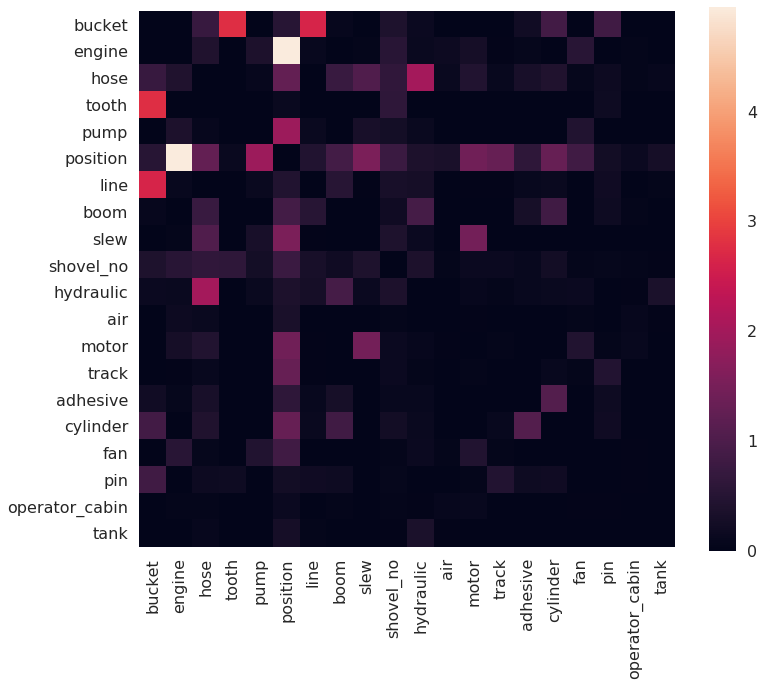

In [83]:
tag_similarity = mlp.tree.node_adj_mat(tag_df["I"])
with sns.axes_style('whitegrid') as style,\
sns.plotting_context('poster') as context:
    plt.figure(figsize=(12,10))
    sns.heatmap(200*tag_similarity.iloc[:20,:20], square=True)

In [84]:
D = mlp.tree.heymann_taxonomy(tag_similarity, dynamic=False, verbose=True, tau=5e-4)


 57%|█████▋    | 106/187 [00:00<00:00, 1059.28it/s]

position


100%|██████████| 187/187 [00:00<00:00, 703.52it/s] 

position
['build', 'plate', 'wiper', 'operator', 'ladder', 'lock', 'supply', 'modify', 'arm', 'weld', 'transfer', 'housing', 'pivot', 'solenoid', 'aerial', 'cable', 'shaft', 'deck', 'shovel', 'mechanical', 'wing', 'frame', 'horn', 'screen', 'indicator', 'deflector', 'heater', 'camera', 'rope', 'spare', 'chain', 'isolate', 'suppression', 'timer', 'hub', 'dashboard', 'breather', 'head', 'request', 'ram', 'interval_hour', 'turn', 'carry', 'airconditioner', 'radio_frequency', 'bearing', 'transmission', 'trap', 'bushing', 'day', 'accessory', 'blade', 'platform', 'storage', 'mirror', 'injection', 'blower', 'cutting', 'component', 'OEM', 'fastener', 'edge', 'flashing', 'rotary', 'body', 'statutory', 'statuatory', 'interval_month', 'controller', 'hour', 'truck', 'list', 'excavator_number', 'actuator', 'would not', 'traction', 'haul', 'stem', 'clutch', 'driver']


101


/home/tbsexton/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/tbsexton/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/home/tbsexton/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


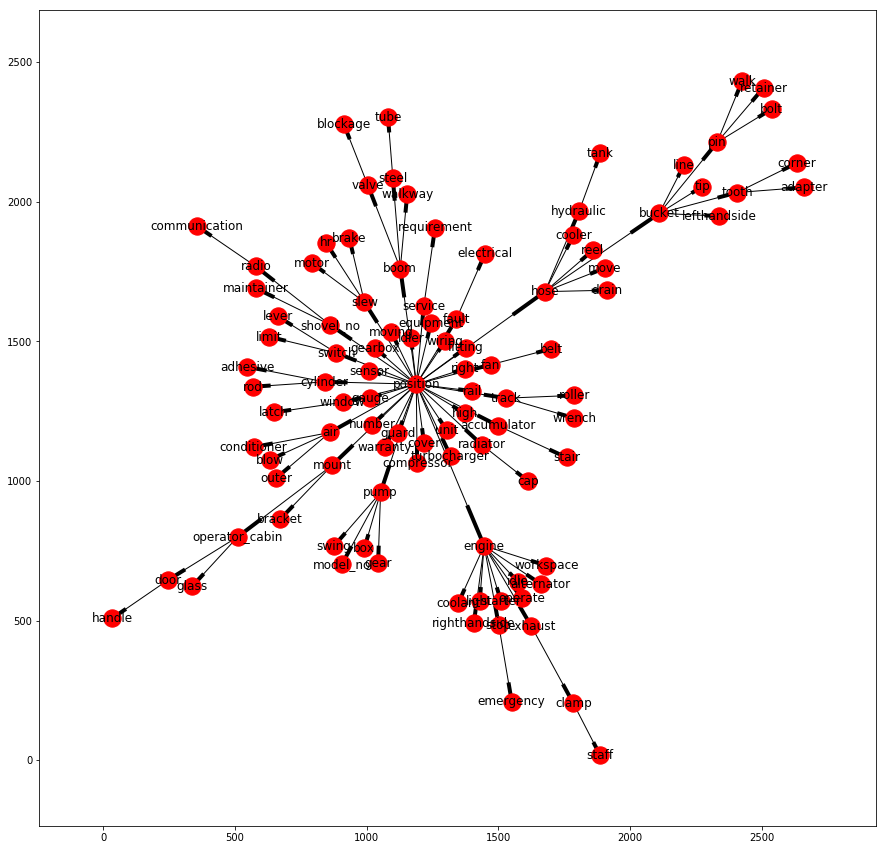

In [85]:
for n, d in enumerate(nx.weakly_connected_component_subgraphs(D)):
    print(nx.number_of_nodes(d))
    plt.figure(figsize=(15,15))
    nx.draw_networkx(d, pos=nx.drawing.nx_pydot.pydot_layout(d, prog='fdp'))
    break

In [86]:
from networkx.readwrite import json_graph
from networkx.algorithms.traversal.depth_first_search import dfs_tree
import json

subD = dfs_tree(D, 'position')

with open('d3tree.json', 'w') as outfile:
    s=json.dump(json_graph.tree.tree_data(subD, 'position'), outfile)

In [87]:
%%writefile f2.template
<!DOCTYPE html>
<meta charset="utf-8">
<style>

.node {
  cursor: pointer;
}

.node circle {
  fill: #fff;
  stroke: steelblue;
  stroke-width: 1.5px;
}

.node text {
  font: 10px sans-serif;
}

.link {
  fill: none;
  stroke: #ccc;
  stroke-width: 1.5px;
}

</style>
<body>
<script src="//d3js.org/d3.v3.min.js"></script>
<script>

var margin = {top: 20, right: 120, bottom: 20, left: 120},
    width = 1400 - margin.right - margin.left,
    height = 900 - margin.top - margin.bottom;

var i = 0,
    duration = 750,
    root;

var tree = d3.layout.tree()
    .size([height, width]);

var diagonal = d3.svg.diagonal()
    .projection(function(d) { return [d.y, d.x]; });

var svg = d3.select("body").append("svg")
    .attr("width", width + margin.right + margin.left)
    .attr("height", height + margin.top + margin.bottom)
  .append("g")
    .attr("transform", "translate(" + margin.left + "," + margin.top + ")");

d3.json("d3tree.json", function(error, flare) {
  if (error) throw error;

  root = flare;
  root.x0 = height / 2;
  root.y0 = 0;

  function collapse(d) {
    if (d.children) {
      d._children = d.children;
      d._children.forEach(collapse);
      d.children = null;
    }
  }

  root.children.forEach(collapse);
  update(root);
});

d3.select(self.frameElement).style("height", "1200px");

function update(source) {

  // Compute the new tree layout.
  var nodes = tree.nodes(root).reverse(),
      links = tree.links(nodes);

  // Normalize for fixed-depth.
  nodes.forEach(function(d) { d.y = d.depth * 180; });

  // Update the nodes…
  var node = svg.selectAll("g.node")
      .data(nodes, function(d) { return d.id || (d.id = ++i); });

  // Enter any new nodes at the parent's previous position.
  var nodeEnter = node.enter().append("g")
      .attr("class", "node")
      .attr("transform", function(d) { return "translate(" + source.y0 + "," + source.x0 + ")"; })
      .on("click", click);

  nodeEnter.append("circle")
      .attr("r", 1e-6)
      .style("fill", function(d) { return d._children ? "lightsteelblue" : "#fff"; });

  nodeEnter.append("text")
      .attr("x", function(d) { return d.children || d._children ? -10 : 10; })
      .attr("dy", ".35em")
      .attr("text-anchor", function(d) { return d.children || d._children ? "end" : "start"; })
      .text(function(d) { return d.id; })
      .style("fill-opacity", 1e-6);

  // Transition nodes to their new position.
  var nodeUpdate = node.transition()
      .duration(duration)
      .attr("transform", function(d) { return "translate(" + d.y + "," + d.x + ")"; });

  nodeUpdate.select("circle")
      .attr("r", 4.5)
      .style("fill", function(d) { return d._children ? "lightsteelblue" : "#fff"; });

  nodeUpdate.select("text")
      .style("fill-opacity", 1);

  // Transition exiting nodes to the parent's new position.
  var nodeExit = node.exit().transition()
      .duration(duration)
      .attr("transform", function(d) { return "translate(" + source.y + "," + source.x + ")"; })
      .remove();

  nodeExit.select("circle")
      .attr("r", 1e-6);

  nodeExit.select("text")
      .style("fill-opacity", 1e-6);

  // Update the links…
  var link = svg.selectAll("path.link")
      .data(links, function(d) { return d.target.id; });

  // Enter any new links at the parent's previous position.
  link.enter().insert("path", "g")
      .attr("class", "link")
      .attr("d", function(d) {
        var o = {x: source.x0, y: source.y0};
        return diagonal({source: o, target: o});
      });

  // Transition links to their new position.
  link.transition()
      .duration(duration)
      .attr("d", diagonal);

  // Transition exiting nodes to the parent's new position.
  link.exit().transition()
      .duration(duration)
      .attr("d", function(d) {
        var o = {x: source.x, y: source.y};
        return diagonal({source: o, target: o});
      })
      .remove();

  // Stash the old positions for transition.
  nodes.forEach(function(d) {
    d.x0 = d.x;
    d.y0 = d.y;
  });
}

// Toggle children on click.
function click(d) {
  if (d.children) {
    d._children = d.children;
    d.children = null;
  } else {
    d.children = d._children;
    d._children = null;
  }
  update(d);
}

</script>

Overwriting f2.template


In [88]:
from IPython.display import IFrame
import re

def replace_all(txt,d):
    rep = dict((re.escape('{'+k+'}'), str(v)) for k, v in d.items())
    pattern = re.compile("|".join(rep.keys()))
    return pattern.sub(lambda m: rep[re.escape(m.group(0))], txt)    

count=0
def serve_html(s,w,h):
    import os
    global count
    count+=1
    fn= '__tmp'+str(os.getpid())+'_'+str(count)+'.html'
    with open(fn,'w') as f:
        f.write(s)
    return IFrame('files/'+fn,w,h)

def f2(w=500,h=400):
    d={
       'width'      :w,
       'height'     :h,
       }
    with open('f2.template','r') as f:
        s=f.read()
    s= replace_all(s,d)        
    return serve_html(s,w+30,h+30)

In [89]:
f2(w=1500,h=1200)

### 2-grams

In [149]:
thes_dict = vocab[vocab.alias.notna()].alias.to_dict()
substr = sorted(thes_dict, key=len, reverse=True)
# matcher = lambda s: r'\b'+re.escape(s)+r'\b'
# matcher = lambda s: re.escape(s)
rx = re.compile(r'\b(' + '|'.join(map(re.escape, substr))+ r')\b')
clean_text = raw_text.str.replace(rx, lambda match: thes_dict[match.group(0)])
clean_text.compute()[:10]

0          bucket will_not t open
1       l h bucket cylinder leak 
2                     swap bucket
3             repair bucket tooth
4             repair bucket tooth
5    repair loose bucket cylinder
6          replace 2 bucket tooth
7          replace absent lip tip
8                     replace lip
9                    build lip  3
dtype: object

In [169]:
from itertools import combinations, permutations, product
tex2 = TokenExtractor(ngram_range = (2,2))
#                       vocabulary=[' '.join(i) for i in combinations(vocab[vocab.alias.notna()].alias.unique(), 2)])
toks2 = tex2.fit_transform(clean_text)
print(tex2.vocab_)


['lube leak' 'lube line' 'position engine' ... 'shovel_no 1fitter' '01 10'
 '19 01']
attempting to initialize with pre-existing vocab
intialized successfully!
saved locally!


In [194]:
voc2 = tex2.annotation_assistant(data_dir/'2g_mine_vocab_test.csv')
NE_dict = vocab.reset_index()[['NE', 'alias']].dropna(subset=['alias']).drop_duplicates().set_index('alias').NE.fillna("U").to_dict()
# NE_dict = vocab.NE.fillna('U').to_dict()
# NE_dict.update(vocab.reset_index()[['NE', 'alias']].drop_duplicates().set_index('alias').NE.fillna("U").to_dict())
NE_sub = sorted(NE_dict, key=len, reverse=True)
# pd.DataFrame.drop_duplicates
# matcher = lambda s: r'\b'+re.escape(s)+r'\b'
# matcher = lambda s: re.escape(s)
NErx = re.compile(r'\b(' + '|'.join(map(re.escape, NE_sub))+ r')\b')
NE_text = voc2.index.str.replace(NErx, lambda match: NE_dict[match.group(0)])
voc2.loc[:,'NE'] = NE_text.tolist()



# g = vocab.groupby('alias')
# for one_grams in voc2.index.str.split().tolist():
#     for one_gram in one_grams:
#         try:
#             print(g.get_group(one_gram).NE[0])
#         except KeyError:
#             pass

NE_map = {' '.join(i):'' for i in product('IPSUX', repeat=2)}

NE_map['I I'] = 'I'
NE_map['S I'] = 'S I'
NE_map['P I'] = 'P I'

NE_map['I S'] = 'S I'
NE_map['I P'] = 'P I'

NE_map['S S'] = 'X'
NE_map['P P'] = 'X'
NE_map['S P'] = 'X'
NE_map['P S'] = 'X'
# NE_map['']
voc2['NE'] = voc2.NE.apply(lambda x: NE_map.get(x, ''))
# voc2_est.to_csv('test_estimated_2g.csv')
# voc2_est[(voc2_est!='') & (voc2_est!='X')]
voc2.loc[voc2.NE=='I','alias'] = voc2[voc2.NE=='I'].index.str.split(' ').str.join('_')
voc2['score'] = tex2.scores_
# voc2.NE

attempting to initialize with pre-existing vocab
intialized successfully!
saved locally!


# OLD

In [138]:
# tqdm.pandas(desc="KEx")
from sklearn.feature_extraction import stop_words
 
# print(stop_words.ENGLISH_STOP_WORDS)

thes_dict = vocab[vocab.alias.notna()].alias.to_dict()
substr = sorted(thes_dict, key=len, reverse=True)
rx = re.compile('|'.join(map(re.escape, substr)))

toks = raw_text.str.split()
toks = toks.apply(lambda d: d if isinstance(d, list) else [], 
                             meta=toks)

tags = raw_text.str.replace(rx, lambda match: thes_dict[match.group(0)]).str.split()
tags = tags.apply(lambda d: d if isinstance(d, list) else [], 
                             meta=tags)

grps = vocab.groupby('NE')

# have to pre-allocate column names...dask doesn't like loops :(
tagI = tags.apply(lambda x: list(set(grps.get_group('I')['alias'].astype(str).tolist()) & set(x)),
                  meta=('I', object)).str.join(', ')
tagP = tags.apply(lambda x: list(set(grps.get_group('P')['alias'].astype(str).tolist()) & set(x)),
                  meta=('P', object)).str.join(', ')
tagS = tags.apply(lambda x: list(set(grps.get_group('S')['alias'].astype(str).tolist()) & set(x)),
                  meta=('S', object)).str.join(', ')

tagU = toks.apply(lambda x: list(set(x) - set(vocab.index) - set(stop_words.ENGLISH_STOP_WORDS)),
                  meta=('U', object)).str.join(', ')

ndf = dd.concat([ tagI, tagP, tagS, tagU], axis=1)


/home/tbsexton/anaconda3/lib/python3.6/site-packages/dask/dataframe/multi.py:571: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indexes of each dataframes are 
aligned. This assumption is not generally safe.
  warn("Concatenating dataframes with unknown divisions.\n"


In [139]:
from dask.diagnostics import ProgressBar, Profiler, ResourceProfiler, CacheProfiler, visualize
from dask.distributed import Client
import dask

## multiproc, not thread, due to GIL with text. 
with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof, CacheProfiler() as cprof:
    with ProgressBar(), dask.set_options(get=dask.multiprocessing.get):
        tag_df=ndf.compute()

# visualize([prof, rprof, cprof])
tag_df.head()

[########################################] | 100% Completed |  3.5s


,I,P,S,U
0,"chain, feeder",broken,repair,
1,"machine, cable, pendant, pin",short,replace,
2,part,broken,"order, repair",
3,accumulator,,"ok, charge, check",
4,"attachment, saw, hydraulic",leak,replace,


In [140]:
tag_df['og'] = raw_text
tag_df

,I,P,S,U,og
0,"chain, feeder",broken,repair,,broken bar feeder chain repaired
1,"machine, cable, pendant, pin",short,replace,,no power replaced pin in pendant and powered m...
2,part,broken,"order, repair",,smartscope harness broken parts ordered tech...
3,accumulator,,"ok, charge, check",,check charge accumulators where ok
4,"attachment, saw, hydraulic",leak,replace,,hyd leak at saw atachment replaced seal in saw...
5,"unit, thread",,"setup, complete",,cs1008 setup change over from arc1004 comple...
6,"saw, gear, shelf, attachment, person, unit",,"remove, replace, rebuild",,gears on saw attachment tight and grinding per...
7,accumulator,,"charge, check",,check and charge accumulators checked and charged
8,"mill, spindle, station",,repair,,st 14 milling spindle repairs reapired
9,"line, hydraulic","rupture, leak",replace,b,hydraulic leak replaced ruptured hydraulic lin...


In [16]:
# nlp_cols = ['Description', 'Resolution']
# nlp_cols=0
# raw_text = df.iloc[:,nlp_cols].fillna('').add(' ').sum(axis=1).str[:-1]

# raw_text = raw_text.str.lower()
# raw_text.str.replace('\n', ' ')
# raw_text = raw_text.str.replace('[{}]'.format(string.punctuation), ' ')

def series_itervals(s):
    for n, val in s.iteritems():
        yield val
# raw_text.compute()

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

# vec = TfidfVectorizer(input='content', 
#                       ngram_range=(1,1),
#                       stop_words='english',
# #                       min_df=2, 
# #                       max_df=0.95,
#                       sublinear_tf=True,
#                       smooth_idf=False,
# #                       max_features=3000
#                      )

# tf = vec.fit(tqdm(series_itervals(raw_text)))


In [18]:
# tf = vec.transform(series_itervals(raw_text))  # CSR sparse array
# tf = tf.toarray()
tf.shape

(696211, 29422)

[('replace', 28671.656586049528),
 ('repair', 23315.672519843509),
 ('service', 18459.533601779585),
 ('oil', 12036.019749034887),
 ('leak', 11195.783407141291),
 ('inspection', 10932.103424049106),
 ('lube', 10514.25589025008),
 ('change', 10369.942455284563),
 ('air', 10333.877317125754),
 ('mechanical', 9512.6087999818319),
 ('engine', 9100.656635962685),
 ('lubrication', 9045.2935483057063),
 ('pm', 9004.4377757877755),
 ('hose', 8688.7022881740795),
 ('pump', 7257.4747167787609),
 ('brake', 7202.1964601366071),
 ('weekly', 7112.7785995961667),
 ('working', 7085.7028709121887),
 ('fault', 6908.7969158723181),
 ('repairs', 6648.2767971289823),
 ('check', 6523.6572009770825),
 ('lights', 6275.9485485594041),
 ('leaking', 6042.0799142608612),
 ('broken', 5316.8478967504361),
 ('start', 5230.6273081447243),
 ('hyd', 5222.4485127463586),
 ('light', 5192.9811273116611),
 ('inspections', 5050.1307590726065),
 ('pos', 4817.8297036323047),
 ('grease', 4804.9494999201734),
 ('changeout', 477

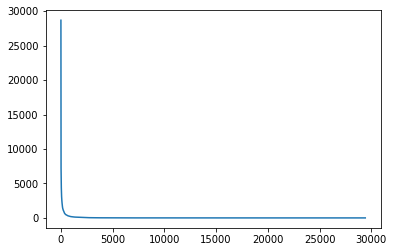

In [24]:
# sort = vec.idf_.argsort()
tf_tot = np.array(tf.sum(axis=0))[0]
sort = tf_tot.argsort()[::-1]

# np.array(vec.get_feature_names())[sort]
plt.plot(tf_tot[sort])
list(zip(np.array(vec.get_feature_names())[sort], tf_tot[sort]))


In [16]:
from numba import jit
import scipy.constants as cnst

# http://cse.iitkgp.ac.in/~pabitra/paper/stemmer.pdf
# @jit
# np.not_equal()

def str_D1(str1,str2, reg=None):
    if reg is None:
        reg = cnst.golden**(-np.arange(str1.shape[0]))
    ser = np.char.not_equal(str1,str2)*reg    
    return ser.sum()

def roll_D1(str1,str2, reg=None):
    if reg is None:
        reg = cnst.golden**(-np.arange(str1.shape[0]))
    ser = np.char.not_equal(str1,str2)*reg    
    
    left=np.roll(str1,1)
    ser_left = np.char.not_equal(left[1:], str2[:-1])*reg[1:]
    right = np.roll(str1,-1)
    ser_right = np.char.not_equal(left[:-1], str2[1:])*reg[1:]
    
    return ser.sum()*(ser_right.sum()+ser_left.sum())

In [17]:
first_zero = lambda l: next((i for i, x in enumerate(l) if x), None) # x!= 0 for strict match

def str_D2(str1,str2):
    lgth = max(len(str1[0]), len(str2[0]))
#     print(lgth)
    a = str1[0].ljust(lgth)
    b = str2[0].ljust(lgth)
    
    ser = [int(i!=j) for i,j in zip(a,b)]
    m = first_zero(ser)
    if (m is not None) and m>0:
        geo_sum = (1-0.5**(lgth-m+1))/(1-0.5)  # \sum_{i=m}^n 1/2^{i-m}
        return geo_sum/m 
    else:
        return 100.

def str_D3(str1,str2):
    lgth = max(len(str1), len(str2))
#     print(lgth)
    a = str1[0].ljust(lgth)
    b = str2[0].ljust(lgth)
    
    ser = [int(i!=j) for i,j in zip(a,b)]
    m = first_zero(ser)
    if (m is not None) and m>0:
        geo_sum = (1-0.5**(lgth-m+1))/(1-0.5)  # \sum_{i=m}^n 1/2^{i-m}
        return (lgth-m)*geo_sum/m 
    else:
        return 100.
    
def str_D4(str1,str2):
    lgth = max(len(str1), len(str2))
#     print(lgth)
    a = str1[0].ljust(lgth)
    b = str2[0].ljust(lgth)
    
    ser = [int(i!=j) for i,j in zip(a,b)]
    m = first_zero(ser)
    geo_sum = (1-0.5**(lgth-m+1))/(1-0.5)  # \sum_{i=m}^n 1/2^{i-m}
    return (lgth-m)*geo_sum/lgth 
    
pd.to_    

In [21]:
strs = np.array(vec.get_feature_names())[sort]
# chars = np.zeros((len(strs), max(len(i) for i in strs)), dtype='unicode_')
# for n,i in enumerate(strs):
#     chars[n, :len(i)] = list(i)
# chars.shape

In [23]:
# http://scikit-learn.org/stable/faq.html#how-do-i-deal-with-string-data-or-trees-graphs
from fuzzywuzzy import process, fuzz
process.extractBests('replace', strs, limit=20, score_cutoff=75)
# process.extract()
# fuzz.WRatio()

# X = np.arange(chars.shape[0]).reshape(-1, 1)  # index look-up
# def str_dist(x,y, reg=None):
#     i,j = int(x[0]), int(y[0])  # extract indices
#     return str_D1(chars[i], chars[j], reg=reg)

[('replace', 100),
 ('replaced', 93),
 ('replacer', 93),
 ('replacel', 93),
 ('rreplace', 93),
 ('replaces', 93),
 ('repalace', 93),
 ('repplace', 93),
 ('rerplace', 93),
 ('reaplace', 93),
 ('1replace', 93),
 ('treplace', 93),
 ('replkace', 93),
 ('reeplace', 93),
 ('replacet', 93),
 ('replaace', 93),
 ('replace5', 93),
 ('replace4', 93),
 ('replacew', 93),
 ('replace3', 93)]

In [163]:
from sklearn.cluster import DBSCAN
clust = DBSCAN(metric=str_dist, eps=.25, n_jobs=-1).fit(X)

grps = pd.DataFrame(index=strs,data=dict(cls=clust.labels_, score=tf_tot[sort][:2000]))
g = grps[grps.cls!=-1].groupby('cls')

grps['score_best'] = grps['score']
grps.loc[grps.cls!=-1,'score_best'] = g['score'].transform(max)
grps.sort_values(['score_best', 'score'], ascending=False).to_csv('clust_vocab_mine.csv', sep='\t')

## Deprecated

In [146]:
from scipy.spatial import distance

# reg=cnst.golden**(-np.arange(X.shape[1]))
# %lprun -f str_D1 distance.pdist(X[:100], str_D1)
distance.squareform(distance.pdist(X[:100], str_D1))

array([[ 0.        ,  0.52786405,  1.76393202, ...,  2.52786405,
         2.52786405,  2.52786405],
       [ 0.52786405,  0.        ,  1.76393202, ...,  2.47213595,
         2.52786405,  2.47213595],
       [ 1.76393202,  1.76393202,  0.        , ...,  2.52786405,
         2.52786405,  2.52786405],
       ..., 
       [ 2.52786405,  2.47213595,  2.52786405, ...,  0.        ,
         2.52786405,  2.47213595],
       [ 2.52786405,  2.52786405,  2.52786405, ...,  2.52786405,
         0.        ,  2.29179607],
       [ 2.52786405,  2.47213595,  2.52786405, ...,  2.47213595,
         2.29179607,  0.        ]])

In [147]:


# sns.clustermap(distance.squareform(distance.pdist(np.array(strs).reshape(-1,1), str_D1)),
#                yticklabels=strs, figsize=(15,20))
dist_mat = pd.DataFrame(data=distance.squareform(distance.pdist(X, str_D1)), 
             index=strs, columns = strs)

/home/tbsexton/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


accumulator     0.000000
accumulators    0.005025
accrepair       0.604878
access          0.604878
acc             0.604878
accessory       0.604878
accident        0.604878
actuator        0.750776
ac              0.986844
acond           0.986844
Name: accumulator, dtype: float64

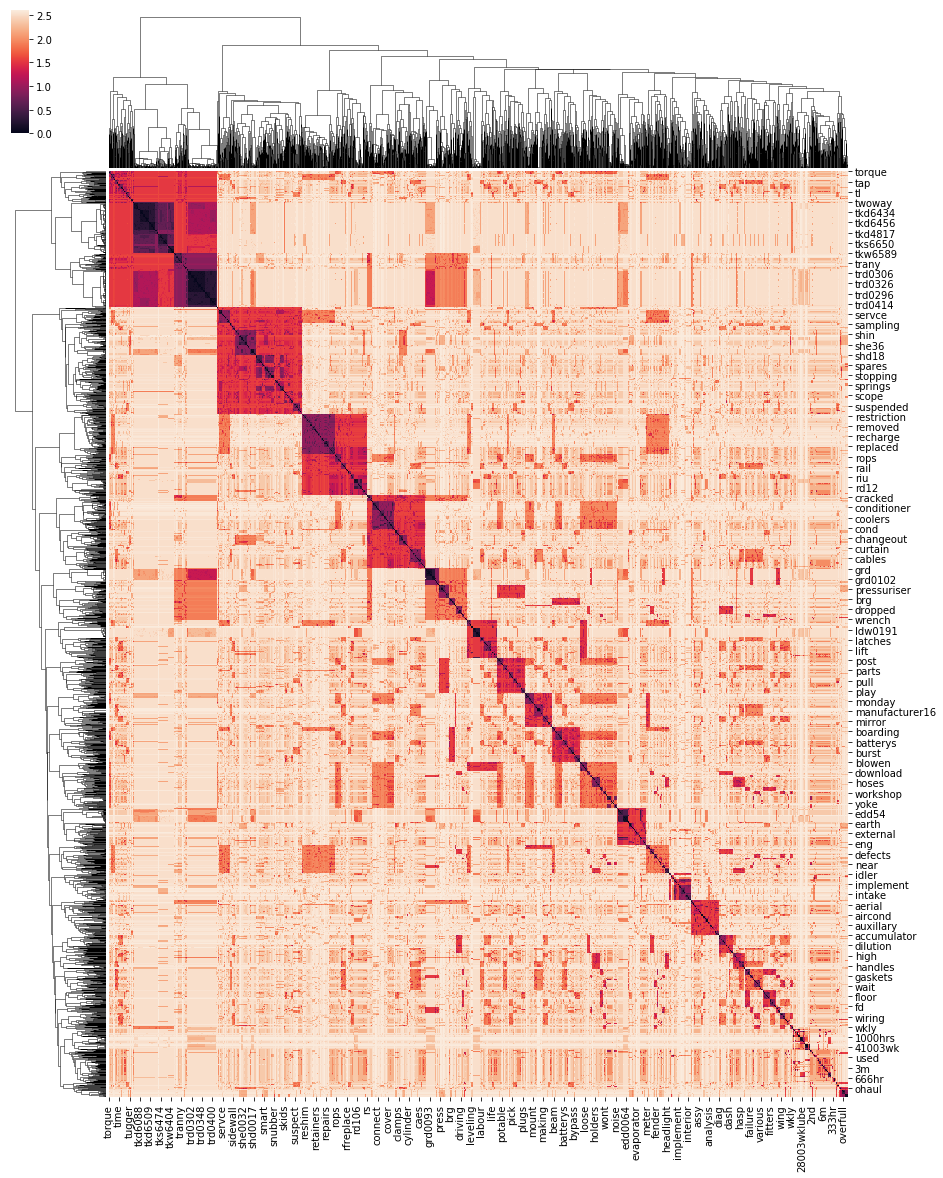

In [148]:
sns.clustermap(dist_mat,
               figsize=(15,20))

dist_mat['accumulator'].sort_values()[:10]

In [150]:
import pprint
from sklearn.cluster import DBSCAN
clust = DBSCAN(metric='precomputed', eps=.25).fit(dist_mat)

grps = pd.DataFrame(index=dist_mat.index,data=dict(cls=clust.labels_, score=tf_tot[sort][:2000]))
g = grps[grps.cls!=-1].groupby('cls')

grps['score_best'] = grps['score']
grps.loc[grps.cls!=-1,'score_best'] = g['score'].transform(max)
grps.sort_values(['score_best', 'score'], ascending=False).to_csv('clust_vocab_mine.csv', sep='\t')

In [218]:
from nltk.metrics.distance import edit_distance
# metrics.distance.edit_distance('abcde','abcfg')
ed_func = lambda x,y: edit_distance(x[0], y[0])
dist_mat = pd.DataFrame(data=distance.squareform(distance.pdist(np.array(strs).reshape(-1,1), 
                                                                ed_func)), 
             index=strs, columns = strs)
dist_mat['accumulator'].sort_values()[:10]

accumulator    0.0
contactor      7.0
motor          7.0
completed      7.0
operator       7.0
conveyor       8.0
clamp          8.0
coolant        8.0
filter         8.0
rebuilt        8.0
Name: accumulator, dtype: float64

In [230]:
vec_mat = vec.transform(series_itervals(raw_text)).toarray().T
dist_mat = pd.DataFrame(data=distance.squareform(distance.pdist(vec_mat,'cosine')), 
             index=strs, columns = strs)
dist_mat['accumulator'].sort_values()[:10]

accumulator    0.000000
check          0.322233
30bar          0.376422
charged        0.413130
requested      0.529558
charge         0.685735
lp             0.701154
25bar          0.723847
tag            0.729880
ok             0.746831
Name: accumulator, dtype: float64

In [11]:
for fname in data_dir.glob('TEMP_init-*.txt'):
    print(fname)

E:\Thurston\Documents\Code\Pycharm\ml-py\data\gs_data\TEMP_init-0.txt


In [129]:
# docs = textacy.fileio.read.read_csv(str(data_dir/'TEMP_init-0.txt'))
# Descriptions in RawText col
# content_stream, metadata_stream = textacy.fileio.split_record_fields(docs, 1)  

corpus = textacy.Corpus(u'en')

for fname in data_dir.glob('TEMP_init-*.txt'):
    print(fname)
    docs = textacy.fileio.read.read_csv(str(fname), delimiter='\t')
    content_stream, _ = textacy.fileio.split_record_fields(docs, 0)  
    corpus.add_texts(content_stream)

/home/tbsexton/Documents/Projects/DiagnosticKB/MaintenanceLanguageProcessing/data/gs_data/TEMP_init-0.txt


In [144]:
vsm = textacy.vsm.Vectorizer(weighting='tfidf',
                             normalize=False,
                             smooth_idf=False,
                             sublinear_tf=True,
                             min_df=2, max_df=0.95)  # each token in >2 docs, <95% of docs

terms_list = (doc.to_terms_list(ngrams=(1, 2, 3),
                                normalize=u'lemma',
                                named_entities=False,
                                filter_stops=True,  # Nope! Not needed :)
                                filter_punct=True,
                                as_strings=True) for doc in corpus)
doc_term_mat = vsm.fit_transform(terms_list)
doc_term_mat

def get_norm_tokens(doc_n, doc_term_mat, id_to_term):
    doc = doc_term_mat[doc_n].toarray()
    # we only care about unique tags, right?
    return set([id_to_term[i] for i in doc.nonzero()[1]])

# list(list(terms_list)[1])

In [145]:
get_norm_tokens(0, doc_term_mat, vsm.id_to_term)

{'bar',
 'bar feeder',
 'bar feeder chain',
 'break',
 'break bar',
 'break bar feeder',
 'chain',
 'feeder',
 'feeder chain',
 'repair'}

In [ ]:
vsm.sublinear_tf()